In [1]:
import numpy as np
import pandas as pd
from math import sqrt

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.spatial.distance import pdist

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [2]:
user_params = {}
user_lml = {}

use_lml = True
f = 'params_simple_kernel.txt'


with open(f, 'r') as fin:
    for _ in range(13995):
        
        u_id = fin.readline().strip()
        if u_id == '':
            # End of file
            break
        params_line = fin.readline().strip()
        
        while not params_line.endswith(']'):
            params_next_line = fin.readline().strip()
            params_line += ' ' + params_next_line
        u_params = np.fromstring(params_line[2:-2], dtype=np.float64, sep=' ')
        user_params[u_id] = u_params
        
        if use_lml:
            lml = int(float(fin.readline().strip()))
            user_lml[u_id] = lml

In [3]:
# NOTE: All parameters are the logarithm of the actual value. 
# Param 0 : variation in sleeping hours
# Param 1 : Long term length scale
# Param 2 : Periodic length scale
# Param 3 : Periodicity
# Param 4 : Noise term
parameters = []

def param_0(param):
    return param

def param_1(param):
#     if param > 50: # For more than half the datapoints tahe trend is the same
#         param = 50
    return param

def param_2(param):
    return param

def param_3(param):
    return param

def param_4(param):
    return param

for user_id, user_parameters in user_params.items():
    try:
        p0 = param_0(np.exp(user_parameters[0]))
        p1 = param_1(np.exp(user_parameters[1]))
        p2 = param_2(np.exp(user_parameters[2]))
        p3 = param_3(np.exp(user_parameters[3]))
        p4 = param_4(np.exp(user_parameters[4]))
    except:
        continue
        
    if use_lml:
          parameters.append([user_id, p0, p1, p2, p3, p4, user_lml[user_id]])
    else:
        parameters.append([user_id, p0, p1, p2, p3, p4])  
        
if use_lml:
    cols = ['id', 'Variation', 'LengthScale', 'PerlengthScale', 'Periodicity', 'Noise', 'LML']
else:
    cols = ['id', 'Variation', 'LengthScale', 'PerlengthScale', 'Periodicity', 'Noise']


parameters_df = pd.DataFrame(parameters, columns=cols)

In [4]:
parameters_df.head()

,id,Variation,LengthScale,PerlengthScale,Periodicity,Noise,LML
0,e960e20f5b2c333b2a583487a0f9fb4fc9eaa7f3,4.403940,11.589928,0.986018,3.752004,0.450977,-87
1,9818205aac48f5124f48d212fe9e265eb59114af,0.436519,8.855980,0.236564,7.594730,0.000010,-80
2,393e32eaa9816fca2861690a96b5c044d8ec7364,1.233908,16.614280,0.400411,4.700337,0.947363,-113
3,47c5c7a68938c89a0ecd9871bc68d15db221daf5,2.381571,7.336442,0.277876,4.668611,0.000129,-59
4,a094c41293bc5097bb6c6ee1ff06567a1245b26d,4.533728,15.323293,0.168319,19.572814,0.000068,-36


<IPython.core.display.Javascript object>


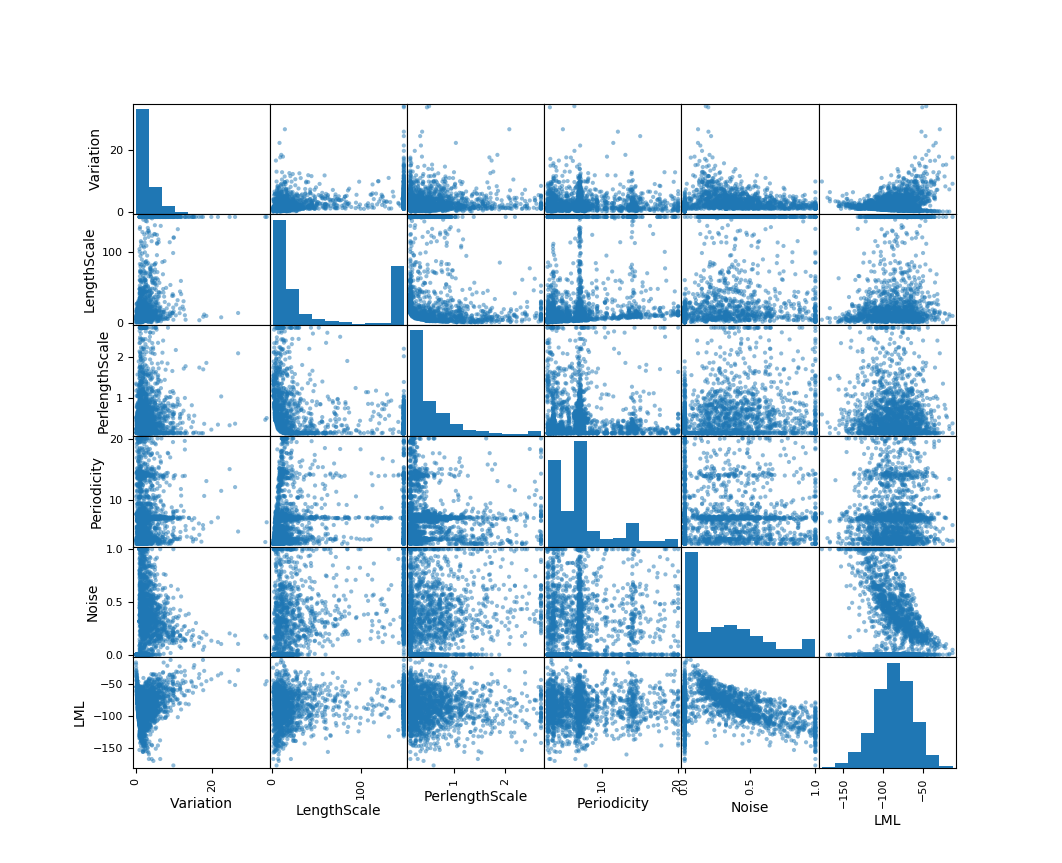

In [6]:
%matplotlib notebook
from pandas.plotting import scatter_matrix

z = scatter_matrix(parameters_df[cols[1:]])  # Plotting without user_id

<IPython.core.display.Javascript object>


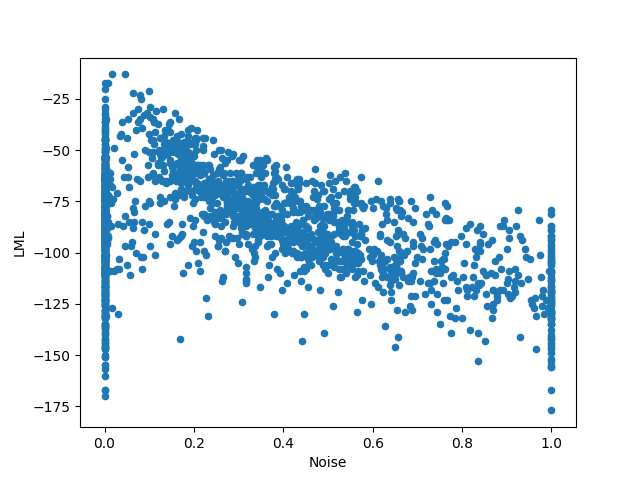

In [7]:
%matplotlib notebook
# 'Variation-l': Long-term variation in amplitude
# 'LengthS-l': Long-term RBF length scale
# 'PerlengthS-l': Long-term periodic kernel length scale
# 'Periodicity-l': Long-term periodicity

# 'Variation-s': Short-term variation in amplitude
# 'LengthS-s': Short-term RBF length scale
# 'PerlengthS-s': Short-term periodic kernel length scale
# 'Periodicity-s': Short-term periodicity

# 'Noise': Noise

# parameters_df.plot(kind='scatter', x='Periodicity', y='PerlengthScale')
parameters_df.plot(kind='scatter', x='Noise', y='LML')

In [5]:
column_names_to_use = ['LengthScale', 'Periodicity']
selected_cols = [cols.index(n) for n in column_names_to_use]
parameters = np.array(parameters)
parameters_subset = parameters[:, selected_cols]
parameters_subset = parameters_subset.astype(np.float32)

parameters_no_id = parameters[:, [1, 2, 3, 4]].astype(np.float32)
mms = MinMaxScaler()
parameters_new = mms.fit_transform(parameters_no_id)

In [6]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
parameters_subset_new = mms.fit_transform(parameters_subset)

In [7]:
dataset = parameters_new

Z = linkage(dataset, 'ward')
c, coph_dists = cophenet(Z, pdist(parameters_subset))  # Cophenetic distance between scaled and unscaled???
print("Cophenetic distance:", c)

Cophenetic distance: 0.9024416878088843


For n_clusters = 2 The average silhouette_score is : 0.5660245
For n_clusters = 3 The average silhouette_score is : 0.46053234
For n_clusters = 4 The average silhouette_score is : 0.46094084
For n_clusters = 5 The average silhouette_score is : 0.43587223


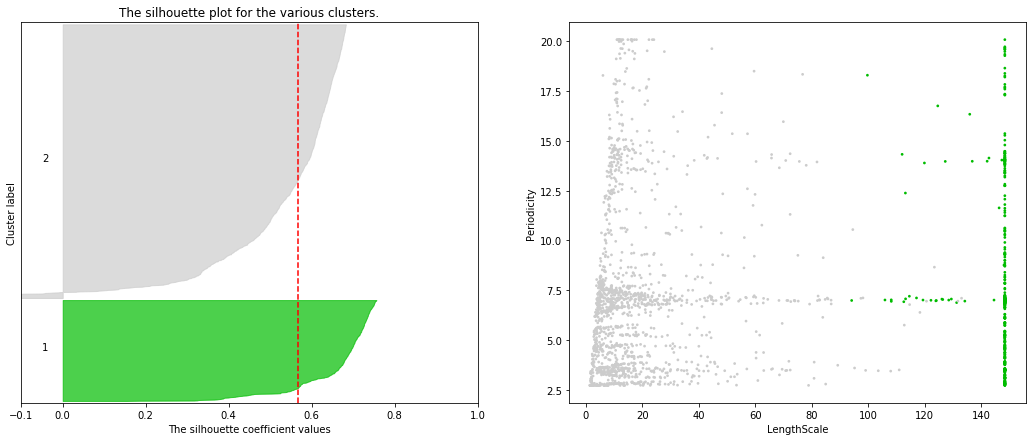

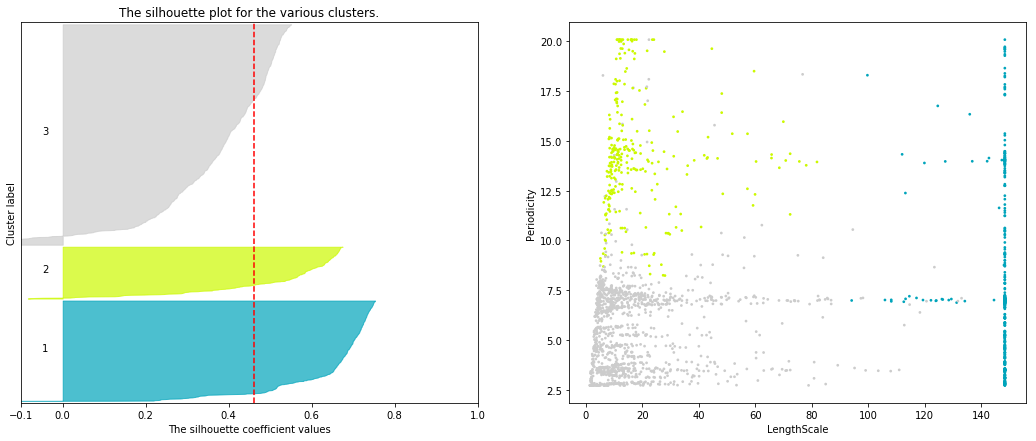

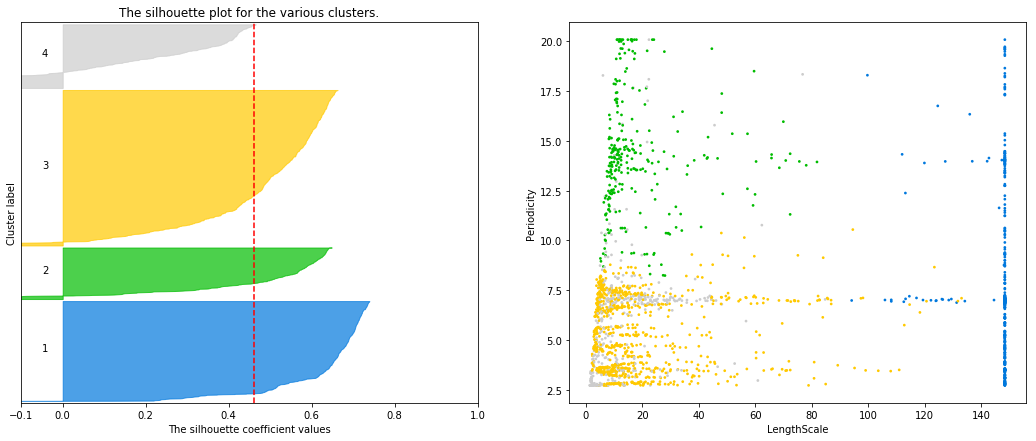

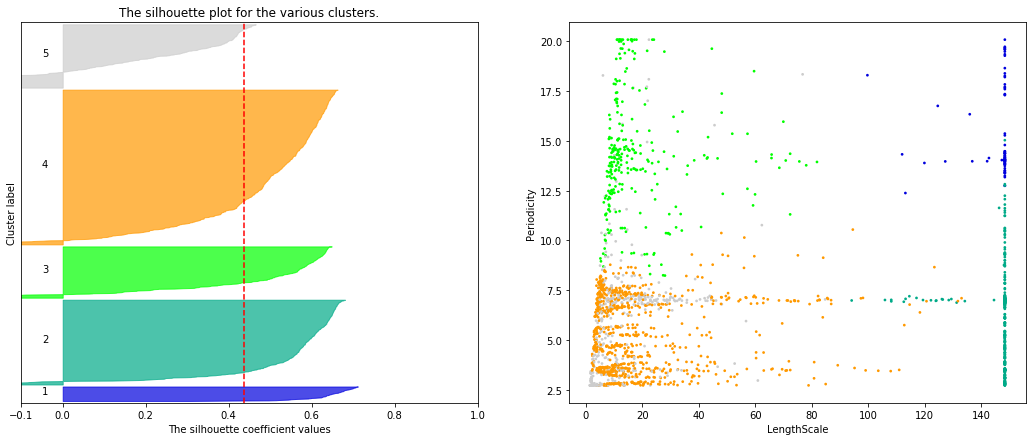

In [9]:
%matplotlib inline
range_n_clusters = [2, 3, 4, 5]

avgs = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(dataset) + (n_clusters + 1) * 10])
    
    # K-means
#     kmeans = KMeans(n_clusters)
#     cluster_labels = kmeans.fit_predict(dataset) + 1
    
    # Hierarchical clustering
    max_k = n_clusters
#     cluster_labels = cluster_labels_all
    cluster_labels = fcluster(Z, max_k, criterion='maxclust')


    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(dataset, cluster_labels)
    avgs.append(silhouette_avg)
    
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(dataset, cluster_labels)

    y_lower = 10
    for i in range(1, n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(parameters_subset[:, 0], parameters_subset[:, 1], marker='.', s=30, lw=0, alpha=1,
                c=colors, edgecolor='k')
    ax2.set_xlabel("LengthScale")
    ax2.set_ylabel("Periodicity")
#     ax2.set_title("Clusters")

plt.savefig("TMP.png", dpi=200)

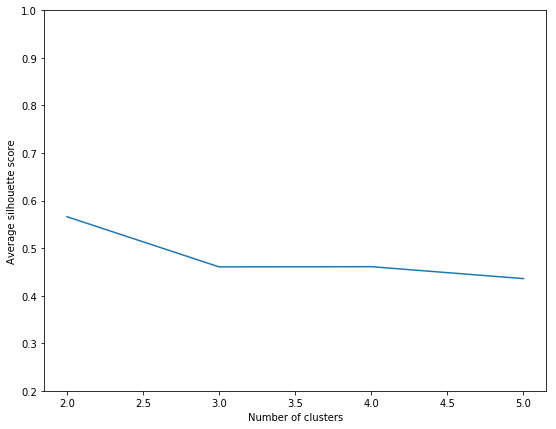

In [10]:
%matplotlib inline

plt.figure(figsize=(9, 7))
plt.plot(range_n_clusters, avgs)
plt.xlabel("Number of clusters")
plt.ylabel("Average silhouette score")
plt.ylim(0.2, 1.0)
plt.savefig("TMP.png", dpi=200)

In [90]:
max_k = 3
cluster_labels = fcluster(Z, max_k, criterion='maxclust')
cluster_labels  # Goes from 1 to max_k included. No 0 cluster.

array([2, 3, 1, ..., 1, 3, 2], dtype=int32)

**Analysing the cluster with user info**

In [92]:
user_info = pd.read_csv('../Dataset/userinfo.csv')

In [93]:
user_info.head()

,linenumber,id,city,timezone,gender,age,height
0,0,f3ca4233a8b87472465aa3e0bddc9cc32dd27152,San Francisco,America/Los_Angeles,Male,40,1.73
1,1,99c9a47a4411a28a9474f9b3b3626865b7b23ca3,London,Europe/Paris,Male,45,1.76
2,2,9d267eb6c6bb164994d16837f1da0bd8e1e2a159,London,Europe/London,Male,41,1.89
3,3,6626af9e2368deddd664b65cc1d6dc109e379248,London,Europe/London,Male,56,1.84
4,4,9ab1e2bfac008c671163ba304ef02d0668ca5a76,San Francisco,America/Los_Angeles,Male,33,1.80


In [94]:
# len(parameters_df) == len(cluster_labels). The ordering between them is the same. So we can use user_id in DataFrame
cluster_info = {}  # {cluster_num: df containing user info}

for cluster_num in range(1, max_k+1):
    indices = np.where(cluster_labels == cluster_num)[0]
    subset_df = parameters_df.iloc[indices]
    if len(subset_df) == 0:
        continue
    t = subset_df.join(user_info.set_index('id'), on='id')
    cluster_info[cluster_num] = t

In [355]:
cluster_num = 2
print("Available columns:", cluster_info[cluster_num].columns)

Available columns: Index(['id', 'Variation', 'LengthScale', 'PerlengthScale', 'Periodicity',
       'Noise', 'LML', 'linenumber', 'city', 'timezone', 'gender', 'age',
       'height'],
      dtype='object')


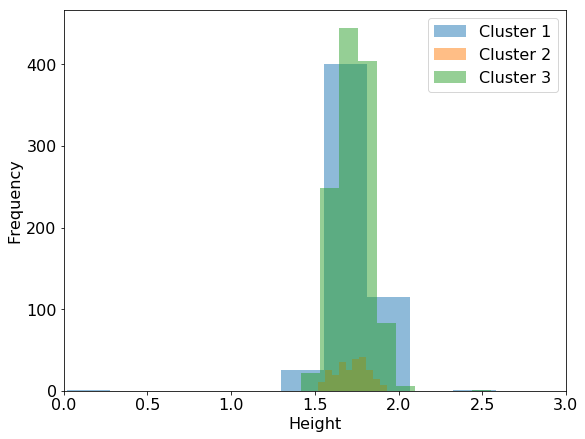

In [111]:
%matplotlib inline

matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(9,7))
for cluster_num in range(1, max_k+1):
    # For continuous data
    data = cluster_info[cluster_num]['height']
    z = plt.hist(data, bins=10, alpha=0.5, label='Cluster '+str(cluster_num))
plt.xlim(0, 3)
plt.legend()
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.savefig("TMP.png", dpi=200)

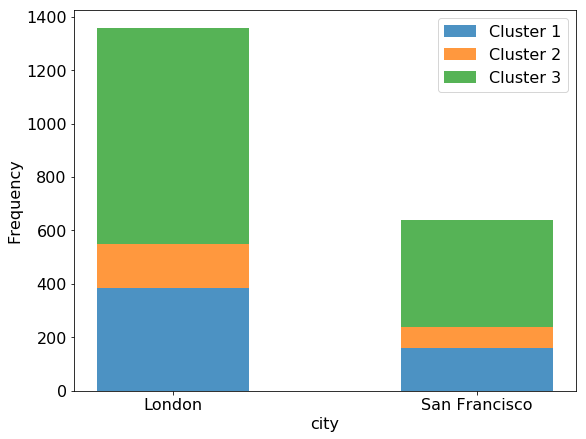

In [109]:
matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(9,7))

col = 'city'
a = cluster_info[1][col].value_counts()
b = cluster_info[2][col].value_counts()
c = cluster_info[3][col].value_counts()
# plt.bar(len(a.axes[0].values), a.values)
lbl = ['London', 'San Francisco']
plt.bar([1, 2], a.values, tick_label=lbl, alpha=0.8, label='Cluster 1', width=0.5)
plt.bar([1, 2], b.values, tick_label=lbl, alpha=0.8, label='Cluster 2', width=0.5, bottom=a.values)
plt.bar([1, 2], c.values, tick_label=lbl, alpha=0.8, label='Cluster 3', width=0.5, bottom=a.values+b.values)

plt.legend()
plt.xlabel(col)
plt.ylabel('Frequency')
plt.savefig("TMP.png", dpi=200)

In [108]:
print(a)
print(a['Male']/a['Female'])
print(b)
print(b['Male']/b['Female'])
print(c)
print(c['Male']/c['Female'])

Male      309
Female    234
Name: gender, dtype: int64
1.3205128205128205
Male      133
Female    112
Name: gender, dtype: int64
1.1875
Male      713
Female    495
Name: gender, dtype: int64
1.4404040404040404


In [360]:
# We also look at average/median statistics of individual columns of the users in the cluster for numerical data

t = pd.DataFrame(columns=parameters_df.columns)
for cluster_num in range(1, max_k+1):
    data = cluster_info[cluster_num]
    t = t.append(data.mean(), ignore_index=True)
    t = t.append(data.std(), ignore_index=True)
# print(t['Periodicity'])
# data = cluster_info[cluster_num]
# data.value_counts()
# data.mean()

In [361]:
t

,id,Variation,LengthScale,PerlengthScale,Periodicity,Noise,LML,age,height,linenumber
0,NaN,4.814540,146.849386,0.363765,7.416642,0.470490,-81.394107,44.014733,1.724088,4565.171271
1,NaN,3.873849,6.549692,0.281110,3.825674,0.236878,21.102354,13.714799,0.131162,2631.426641
2,NaN,2.222268,19.951235,0.453317,15.217983,0.206725,-87.130612,44.118367,1.720653,4820.636735
3,NaN,2.244641,17.185565,0.542590,2.427754,0.276423,24.300865,13.333916,0.093745,2465.575523
4,NaN,2.313862,17.722206,0.674110,5.661472,0.247375,-88.778974,43.808775,1.729685,4448.204470
5,NaN,2.285890,17.791171,0.629512,2.091274,0.301027,25.529196,13.673274,0.103341,2665.277991
